<a href="https://www.kaggle.com/code/dalloliogm/pgs5e8-bank-autogluon?scriptVersionId=253708845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Bank classification using Autogluon


Autogluon is a auto-ML library from Amazon. It can automatically try several approaches for prediction, and choose the optimal parameters given target metrics to optimize. It also automatically handles cross-validation, although that is not always enabled for all the presets.

Feel free to copy this notebook and adapt it. Some ideas on how to improve it:
- add more feature engineering
- Try different autogluon presets, or run it for longer
- Tweak the autogluon hyperparameters to add/remove more models
- Plot results and inspect them

## Install Libraries and set Configuration

Installing Autogluon takes time, on Kaggle, but once that is done, we don't need anything else.

In [1]:
# %%capture
# !pip install -U autogluon

In [2]:
%%capture
!pip install -q xgboost==1.7.6 scikit-learn==1.3.2

In [3]:
# %%capture
import os
import shutil
import seaborn as sns

target_dir = "/kaggle/working/"
source_dir = "/kaggle/input/autogluon-package/"

if not os.path.exists(os.path.join(target_dir, "autogluon")):
    shutil.copytree(source_dir, target_dir, dirs_exist_ok=True)
    print("Copied autogluon installation files.")

!pip install -f --quiet --no-index --find-links='/kaggle/input/autogluon-package' 'autogluon.tabular-1.3.1-py3-none-any.whl'


Copied autogluon installation files.
Looking in links: --quiet, /kaggle/input/autogluon-package
Processing ./autogluon.tabular-1.3.1-py3-none-any.whl
Processing /kaggle/input/autogluon-package/scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.core-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.features-1.3.1-py3-none-any.whl (from autogluon.tabular==1.3.1)
Processing /kaggle/input/autogluon-package/autogluon.common-1.3.1-py3-none-any.whl (from autogluon.core==1.3.1->autogluon.tabular==1.3.1)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [4]:
# Autogluon configuration. Automatically detects if we are using an interactive notebook, and use lower defaults when debugging
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    #                  minutes     seconds       # hours
    "autogluon_time": 60       *  60        *   3,
    "autogluon_preset": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file. Useful for debugging
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_preset"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 10800, 'autogluon_preset': 'best_quality', 'tail_rows': 0}


In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Autogluon parameters

In [6]:
hyperparameters = {
    'GBM': {},      # LightGBM
    'CAT': {},      # CatBoost
    'RF': {},       # RandomForest
    'XT': {},       # ExtraTrees
    'KNN': {},      # k-NN
    # 'NN': {},       # MXNet neural-net
    'LR': {},       # LinearModel
    'XGB': {        # XGBoost 
    },
    'TABPFN': {},
    'ENS_WEIGHTED' : {},
    'NN_TORCH': {},
    'IM_BOOSTEDRULES' : {}
}

# 'RF', 'XT', 'KNN', 'GBM', 'CAT', 'XGB', 'NN_TORCH', 'LR', 'FASTAI', 'AG_TEXT_NN', 'AG_IMAGE_NN', 
# 'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 'FASTTEXT', 'ENS_WEIGHTED', 'SIMPLE_ENS_WEIGHTED',
# 'IM_RULEFIT', 'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 'IM_BOOSTEDRULES', 'DUMMY']

## Load Data

In [7]:
import pandas as pd
# data
path        = '/kaggle/input/playground-series-s5e8/'
train       = pd.read_csv(path + 'train.csv',             index_col = 'id')
test        = pd.read_csv(path + 'test.csv',              index_col = 'id')
submission  = pd.read_csv(path + 'sample_submission.csv', index_col = 'id')

# Reduce dataset size for debugging
if config["tail_rows"] > 0:
    train = train.head(config["tail_rows"])

In [8]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,,,,
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [9]:
test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [10]:
submission.head

<bound method NDFrame.head of           y
id         
750000  0.5
750001  0.5
750002  0.5
750003  0.5
750004  0.5
...     ...
999995  0.5
999996  0.5
999997  0.5
999998  0.5
999999  0.5

[250000 rows x 1 columns]>

# Set up Training

In [11]:
# 2) Fit all models under regression:
predictor = TabularPredictor(
    label='y',
    problem_type='binary',
    eval_metric="roc_auc",
).fit(
    train,
    hyperparameters=hyperparameters,
    time_limit = config["autogluon_time"],
    presets = config["autogluon_preset"],
    ag_args_fit={'num_gpus': 1}
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250801_162851"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.93 GB / 31.35 GB (95.5%)
Disk Space Avail:   16.00 GB / 19.52 GB (82.0%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

[1000]	valid_set's binary_logloss: 0.144497
[2000]	valid_set's binary_logloss: 0.143644
[3000]	valid_set's binary_logloss: 0.143596


	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.144232
[2000]	valid_set's binary_logloss: 0.143542
[3000]	valid_set's binary_logloss: 0.143457


	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.145229
[2000]	valid_set's binary_logloss: 0.144174
[3000]	valid_set's binary_logloss: 0.144072
[4000]	valid_set's binary_logloss: 0.144229


	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.143195
[2000]	valid_set's binary_logloss: 0.142263
[3000]	valid_set's binary_logloss: 0.141992


	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.143546
[2000]	valid_set's binary_logloss: 0.142717
[3000]	valid_set's binary_logloss: 0.142645


	Training S1F6 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.141277
[2000]	valid_set's binary_logloss: 0.140242
[3000]	valid_set's binary_logloss: 0.139876
[4000]	valid_set's binary_logloss: 0.139941


	Training S1F7 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.144676
[2000]	valid_set's binary_logloss: 0.143819
[3000]	valid_set's binary_logloss: 0.143885


	Training S1F8 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.143913
[2000]	valid_set's binary_logloss: 0.142851


	0.9687	 = Validation score   (roc_auc)
	501.4s	 = Training   runtime
	46.24s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 1236.03s of the 2134.95s of remaining time.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
	0.9634	 = Validation score   (roc_auc)
	124.96s	 = Training   runtime
	18.6s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 1090.90s of the 1989.82s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU tra

[16:45:06] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:46:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:46:31] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:47:57] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:49:23] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:49:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:50:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:50:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:52:32] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:52:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[16:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	0.9595	 = Validation score   (roc_auc)
	795.57s	 = Training   runtime
	2.51s	 = Validation runtime
Fitting model: LinearModel_BAG_L1 ... Training model for up to 32.54s of the 931.46s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Early stopping due to lack of time remaining. Fit 100/10000 iters...
	Time limit exceeded... Skipping LinearModel_BAG_L1.
Fitting model: NeuralNetTorch_BAG_L1 ... Training model for up to 23.36s of the 922.28s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping NeuralNetTorch_BAG_L1.
Fitting model: BoostedRules_BAG_L1 ... Training model for up to 9.31s of the 908.23s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		Unable to import dependency imodels. A quick tip is to install via `pip install imodels`. 
Fitting model: WeightedEnsemble_L2 ... Training m

[17:06:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:06:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:06:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:07:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:07:42] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:08:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:08:34] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:09:23] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:09:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:10:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:10:22] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:11:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	0.9673	 = Validation score   (roc_auc)


[17:13:35] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.



	453.42s	 = Training   runtime
	2.85s	 = Validation runtime
Fitting model: LinearModel_BAG_L2 ... Training model for up to 16.73s of the 16.69s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping LinearModel_BAG_L2.
Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 12.71s of the 12.67s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping NeuralNetTorch_BAG_L2.
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.00s of the 5.33s of remaining time.
	Ensemble Weights: {'LightGBM_BAG_L2': 0.714, 'RandomForest_BAG_L2': 0.286}
	0.9695	 = Validation score   (roc_auc)
	32.81s	 = Training   runtime
	0.11s	 = Validation runtime
AutoGluon training complete, total runtime = 2726.62s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 1418.3 rows/s (83334 batch size)
TabularPre

[17:15:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:15:48] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

Deleting DyStack predictor artifacts (clean_up_fits=True) ...
Leaderboard on holdout data (DyStack):
                  model  score_holdout  score_val eval_metric  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L3       0.970155   0.969550     roc_auc       84.978742     111.536057  1915.768755                 0.002551                0.108327          32.812135            3       True         13
1       LightGBM_BAG_L2       0.970105   0.969445     roc_auc       82.974302      93.320187  1706.515419                 1.938963                1.922372          44.856353            2       True          8
2        XGBoost_BAG_L2       0.969901   0.967252     roc_auc       83.507253      94.251597  2115.075261                 2.471915                2.853783         453.416195            2       True         12
3       CatBoost_BAG_L2       0.969821   0.969008     roc_auc  

[1000]	valid_set's binary_logloss: 0.144428
[2000]	valid_set's binary_logloss: 0.143434
[3000]	valid_set's binary_logloss: 0.14319
[4000]	valid_set's binary_logloss: 0.143289


	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.144393
[2000]	valid_set's binary_logloss: 0.143224
[3000]	valid_set's binary_logloss: 0.143193


	Training S1F3 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.142261
[2000]	valid_set's binary_logloss: 0.141095
[3000]	valid_set's binary_logloss: 0.14084


	Training S1F4 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.143498
[2000]	valid_set's binary_logloss: 0.142435
[3000]	valid_set's binary_logloss: 0.142165


	Training S1F5 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.143445
[2000]	valid_set's binary_logloss: 0.142304
[3000]	valid_set's binary_logloss: 0.142037


	Training S1F6 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.141107
[2000]	valid_set's binary_logloss: 0.140081
[3000]	valid_set's binary_logloss: 0.139877
[4000]	valid_set's binary_logloss: 0.14009


	Training S1F7 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.145036
[2000]	valid_set's binary_logloss: 0.143903


	Training S1F8 with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's binary_logloss: 0.145071
[2000]	valid_set's binary_logloss: 0.143987
[3000]	valid_set's binary_logloss: 0.143733
[4000]	valid_set's binary_logloss: 0.14392


	0.9689	 = Validation score   (roc_auc)
	555.25s	 = Training   runtime
	84.54s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 4668.34s of the 7328.84s of remaining time.
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
	0.9634	 = Validation score   (roc_auc)
	137.72s	 = Training   runtime
	19.41s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 4509.60s of the 7170.09s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Training S1F1 with GPU, note that this may negatively impact model quality compared to CPU training.
	Training S1F2 with GPU, note that this may negatively impact model quality compared to CPU t

[17:41:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:48:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:48:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:54:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[17:54:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:01:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:01:23] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:08:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:08:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:15:32] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:15:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:23:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	0.9658	 = Validation score   (roc_auc)
	3600.17s	 = Training   runtime
	7.43s	 = Validation runtime
Fitting model: LinearModel_BAG_L1 ... Training model for up to 150.29s of the 2810.79s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is 

[18:53:34] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:57:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[18:57:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:00:42] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:00:48] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:04:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:04:34] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:08:25] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:08:31] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:12:31] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:12:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:16:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	0.9698	 = Validation score   (roc_auc)
	2033.08s	 = Training   runtime
	3.95s	 = Validation runtime
Fitting model: LinearModel_BAG_L2 ... Training model for up to 84.38s of the 84.32s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Early stopping due to lack of time remaining. Fit 100/10000 iters...
	Time limit exceeded... Skipping LinearModel_BAG_L2.
Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 71.32s of the 71.26s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Time limit exceeded... Skipping NeuralNetTorch_BAG_L2.
Fitting model: WeightedEnsemble_BAG_L2 ... Training model for up to 63.14s of the 63.08s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	0.969	 = Validation score   (roc_auc)
	61.23s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ... Tr

In [12]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.969856,roc_auc,165.534579,7639.429103,0.121607,45.314404,3,True,15
1,XGBoost_BAG_L2,0.969754,roc_auc,143.611879,7118.926002,3.947964,2033.075875,2,True,13
2,LightGBM_BAG_L2,0.969703,roc_auc,141.715732,5133.547451,2.051817,47.697323,2,True,9
3,CatBoost_BAG_L2,0.969545,roc_auc,140.345734,5315.066958,0.681818,229.216830,2,True,11
4,RandomForest_BAG_L2,0.969069,roc_auc,158.731373,5284.124671,19.067458,198.274544,2,True,10
5,WeightedEnsemble_L2,0.969067,roc_auc,108.762802,718.081950,0.123899,23.911209,2,True,8
6,WeightedEnsemble_BAG_L2,0.969045,roc_auc,139.677569,5147.084689,0.013654,61.234562,2,True,14
7,LightGBM_BAG_L1,0.968941,roc_auc,84.544656,555.247433,84.544656,555.247433,1,True,2
8,ExtraTrees_BAG_L2,0.968790,roc_auc,158.292209,5153.930424,18.628294,68.080297,2,True,12
9,XGBoost_BAG_L1,0.965835,roc_auc,7.433394,3600.165834,7.433394,3600.165834,1,True,6


In [13]:
import matplotlib.pyplot as plt

# Compute and plot feature importance
importance_df = predictor.feature_importance(data=train)


Computing feature importance via permutation shuffling for 16 features using 5000 rows with 5 shuffle sets...
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warni

[19:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:29:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	865.09s	= Expected runtime (173.02s per shuffle set)


[19:29:46] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.



/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:31:05] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:06] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:08] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:10] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:11] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:31:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:32:50] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:32:55] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:33:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:34:33] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:33] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:34] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:35] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:35] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:36] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:54] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:34:56] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:36:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:18] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:20] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:27] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:37] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:36:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:37:58] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:37:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:37:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:00] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:01] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:03] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:38:10] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

	516.78s	= Actual runtime (Completed 5 of 5 shuffle sets)


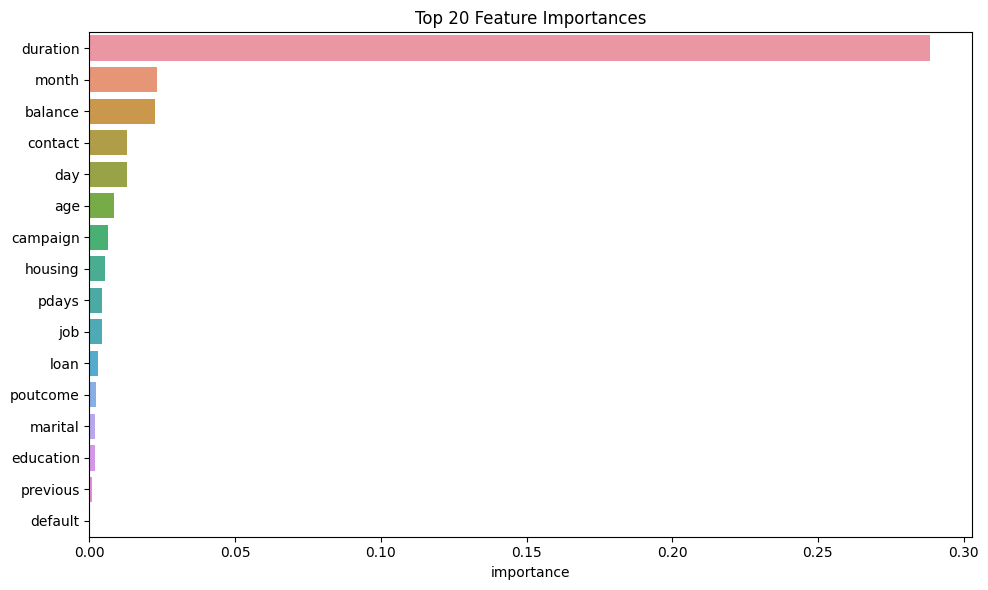

In [14]:
top_features = importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='importance', y=top_features.index)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Save Submission

In [15]:
preds = predictor.predict_proba(test)
preds

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:42:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:16] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:21] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:24] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:26] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:43] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:44] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:42:47] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

,0,1
id,,
750000,0.999088,0.000912
750001,0.912494,0.087506
750002,0.999559,0.000441
750003,0.999579,0.000421
750004,0.985834,0.014166
...,...,...
999995,0.999587,0.000413
999996,0.918604,0.081396
999997,0.307103,0.692897


In [16]:
preds = predictor.predict_proba(test)[1]  # Probability for class 1
submission['y'] = preds
submission = submission.reset_index()
# Save submission
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:46:57] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:00] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:02] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:04] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:09] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:12] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:14] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:28] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:30] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:47:32] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

## Prediction distributions

This dataset is unbalanced, as there about 3x 0s than 1s.

Autogluon should handle it automatically, although the predictions do not look very good, as they don't have the same distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Observed Y')

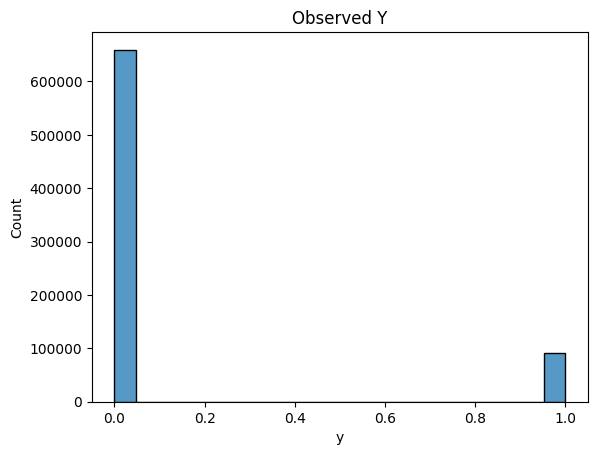

In [17]:
sns.histplot(train.y).set_title("Observed Y")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Predicted Y')

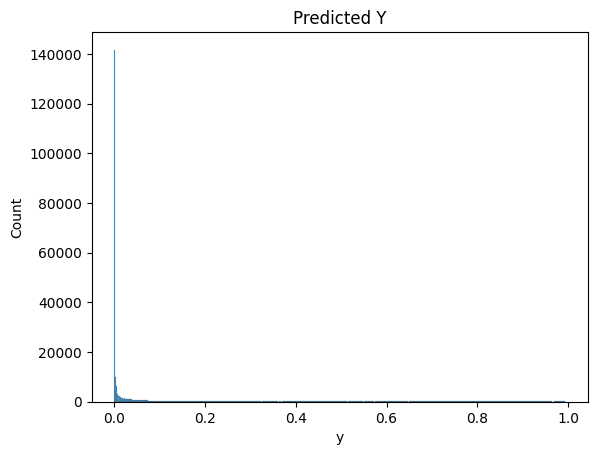

In [18]:
import seaborn as sns
sns.histplot(submission.y).set_title("Predicted Y")

### AUC plot

We plot the ROC Curve, although we use the train test, as cross validation is handled internally by Autogluon and we did not split train/test.



/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instanc

[19:59:39] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:59:45] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:59:52] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[19:59:59] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:00:06] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:00:13] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:00:21] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:00:29] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:01:07] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:01:11] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:01:15] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[20:01:19] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not

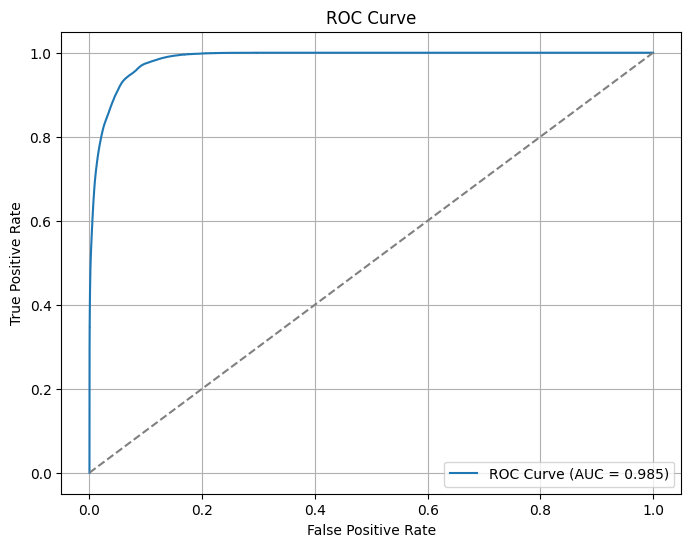

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Get predicted probabilities (for class 1)
y_true = train['y']
y_pred = predictor.predict_proba(train.drop(columns=['y']))[1]

# Step 2: Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [20]:
test

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
id,,,,,,,,,,,,,,,,
750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success


## Cleanup

Delete all the files for installing Autogluon - let's save Kaggle a bit of disk storage costs.

In [21]:
if not is_interactive_session():
    os.system("rm -rf /kaggle/working/*")
    print("Clean-up complete: deleted files from /kaggle/working/")
else:
    print("Not an interactive session. Skipping clean-up.")

Clean-up complete: deleted files from /kaggle/working/
